# A multivariate regression problem

In [1]:
import pandas
import numpy as np
import sklearn.linear_model as lm
from sklearn.model_selection import KFold
from sklearn import preprocessing as pre
import random
import matplotlib.pyplot as plt

Load in the California housing dataset. Originally downloaded from https://github.com/ageron/handson-ml/tree/master/datasets/housing

In [3]:
housing = pandas.read_csv('./housing.csv')

In [4]:
display(housing)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


This dataset has some special features which need some attention:
1. The variable ocean_proximity is a categorical variable
2. There are some missing values in the total_bedrooms column
Let us consider how to deal with each of these.

First, deal with the categorical variable ocean_proximity. How many distinct values does this take?

In [5]:
print(set(housing.ocean_proximity.values))
print(len(set(housing.ocean_proximity.values)))

{'NEAR OCEAN', '<1H OCEAN', 'NEAR BAY', 'INLAND', 'ISLAND'}
5


There are five unique values and so we will replace this with a one-hot vector of length 5 where 10000 corresponds to <1H OCEAN, 01000 is ISLAND etc. This is a standard way to represent categorical factors. The key is that for any entry (row) only one element of this vector should be 1 - hence one-hot.

In [6]:
housing['1h_ocean'] = [1 if i=='<1H OCEAN' else 0 for i in housing.ocean_proximity.values]
housing['island'] = [1 if i=='ISLAND' else 0 for i in housing.ocean_proximity.values]
housing['inland'] = [1 if i=='INLAND' else 0 for i in housing.ocean_proximity.values]
housing['near_ocean'] = [1 if i=='NEAR OCEAN' else 0 for i in housing.ocean_proximity.values]
housing['near_bay'] = [1 if i=='NEAR BAY' else 0 for i in housing.ocean_proximity.values]
housing.drop(columns=['ocean_proximity'], inplace=True)
display(housing)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,1h_ocean,island,inland,near_ocean,near_bay
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,0,1
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,0,1
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,0,1
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,0,1
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,0,1
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,0,0,0,0,1
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,0,0,0,0,1
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,0,0,0,0,1
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,0,0,0,0,1
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,0,0,0,0,1


Now we need to look at the missing values in total_bedrooms, of which there are:

In [7]:
sum(housing.total_bedrooms.isna())

207

How can we deal with this? It depends. There are several strategies one can use.

* Replace with the average of the column, but this loses information about correlation
* Replace with the values from the nearest neighbour, based on the values of the other variables.
* Use some prior knowledge.

We will use some prior knowledge that it is highly likely that the number of bedrooms is strongly correlated with the total number of rooms. We'll fit a linear model to predict the missing values.

In [8]:
# Get the non-Nan indices
notna = housing.total_bedrooms.notna()

In [9]:
model = lm.LinearRegression()
model.fit(housing.total_rooms.values[notna].reshape(-1,1), housing.total_bedrooms.values[notna].reshape(-1,1))
model.score(housing.total_rooms.values[notna].reshape(-1,1), housing.total_bedrooms.values[notna].reshape(-1,1))

0.8656060227407114

This is a strong prediction so our intuition is correct. Now we predict the missing values.

In [10]:
isna = housing.total_bedrooms.isna()
missing_bedrooms = model.predict(housing.total_rooms.values[isna].reshape(-1,1))

Insert the imputed values into the table.

In [11]:
# Can ignore subsequent warning
housing.total_bedrooms.loc[isna] = np.squeeze(missing_bedrooms)

C:\Users\Percival\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
display(housing)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,1h_ocean,island,inland,near_ocean,near_bay
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,0,1
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,0,1
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,0,1
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,0,1
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,0,1
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,0,0,0,0,1
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,0,0,0,0,1
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,0,0,0,0,1
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,0,0,0,0,1
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,0,0,0,0,1


So we now have a complete dataset. Can we model it? An obvious thing to try first is a linear model, in which the house price is a weighted sum of the inputs; that is:
$$y = w_0 + w_1 x_1 + w_2 x_2 + w_M x_M$$
Let's assess this via cross-validation

In [13]:
# First, extract the data into arrays
y = housing.median_house_value.values.reshape(-1,1)
X = housing.drop(columns=['median_house_value'], inplace=False).values
print(X.shape)
print(y.shape)
# Pull out 1000 values into a holdout set
holdout = random.sample(range(0,10640),1000)
X_holdout = X[holdout]
y_holdout = y[holdout]
Xt = np.delete(X, holdout, 0)
yt = np.delete(y, holdout, 0)
print(Xt.shape)
print(yt.shape)

(20640, 13)
(20640, 1)
(19640, 13)
(19640, 1)


In [14]:
Model = lm.LinearRegression()
# Have to shuffle the data because it is grouped.
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(Xt):
    X_train, X_test = Xt[train_index], Xt[test_index]
    y_train, y_test = yt[train_index], yt[test_index]
    Model.fit(X_train, y_train)
    print('Training error: ' + str(Model.score(X_train, y_train)))
    print('Testing error: ' + str(Model.score(X_test, y_test)))

Training error: 0.6393639449149275
Testing error: 0.6672067603288536
Training error: 0.6451474269097124
Testing error: 0.6448967186373415
Training error: 0.6479176307597897
Testing error: 0.6337490497954412
Training error: 0.646323207828232
Testing error: 0.6402327045130718
Training error: 0.6479025825146987
Testing error: 0.6329081693008227


Scores quoted are $R^2$ (coefficient of determination) values which range from 0 to 1. These are OK but there is much room for improvement and we ought to be able to do much better than this. Options that we could try are:

* Normalising/rescaling the data so that all variables have similar values?
* Expanding the basis to include terms that are non-linear in the variables?
* Removing redundant variables from the data - are there any that are correlated with each other?
* Regularisation?

This will be the task of the group assignment.

## The code below is for feature scaling (normalisation):

In [ ]:
import pandas as pd
from sklearn import preprocessing
import xlsxwriter

# need to make sure there are only numbers and that there are no Nan/blank cells in the data 
# before running this code
df = pd.read_excel('housing.xls')

standard = preprocessing.StandardScaler().fit(df)
df = standard.transform(df)

workbook = xlsxwriter.Workbook('housing_normalised.xlsx')
worksheet = workbook.add_worksheet()

row = 0
col = 0

for a,b,c,d,e,f,g,h,i,j in (df):
    worksheet.write(row, col,     a)
    worksheet.write(row, col + 1, b)
    worksheet.write(row, col + 2, c)
    worksheet.write(row, col + 3, d)
    worksheet.write(row, col + 4, e)
    worksheet.write(row, col + 5, f)
    worksheet.write(row, col + 6, g)
    worksheet.write(row, col + 7, h)
    worksheet.write(row, col + 8, i)
    worksheet.write(row, col + 8, j)
    row += 1
    
workbook.close()

## Data Transformation

## Box Cox Transformation
A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn’t normal, applying a Box-Cox means that you are able to run a broader number of tests.

The Box Cox transformation is named after statisticians George Box and Sir David Roxbee Cox who collaborated on a 1964 paper and developed the technique.

lambda = 0.124748


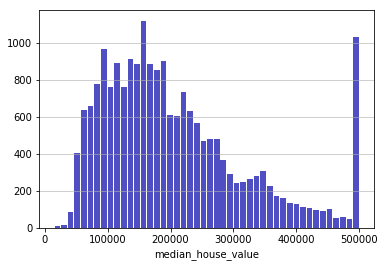

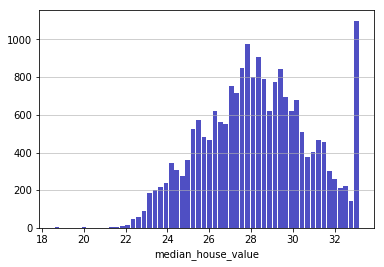

In [15]:
from scipy import stats

median_house_value_bc, maxlog, interval = stats.boxcox(housing.median_house_value, alpha=0.05)
print("lambda = {:g}".format(maxlog))
#print(xtvalue)
#print("lambda = {:g}".format(maxlog))
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.median_house_value, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('median_house_value')
plt.grid(axis='y', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(x=median_house_value_bc, bins='auto',color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('median_house_value')
plt.grid(axis='y', alpha=0.75)
plt.show()

lambda = 0.235768


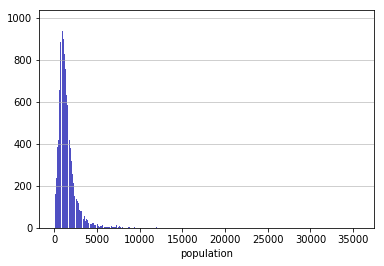

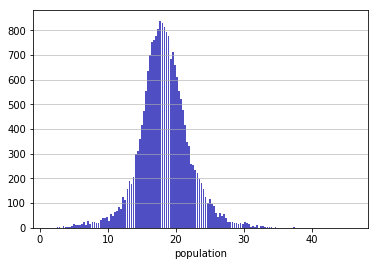

In [16]:
from scipy import stats

population_bc, maxlog, interval = stats.boxcox(housing.population, alpha=0.05)
print("lambda = {:g}".format(maxlog))
#print(xt)
#print("lambda = {:g}".format(maxlog))
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.population, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('population')
plt.grid(axis='y', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(x=population_bc, bins='auto',color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('population')
plt.grid(axis='y', alpha=0.75)
plt.show()

lambda = 0.809398


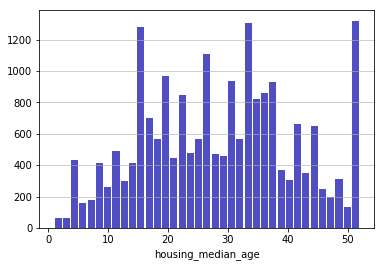

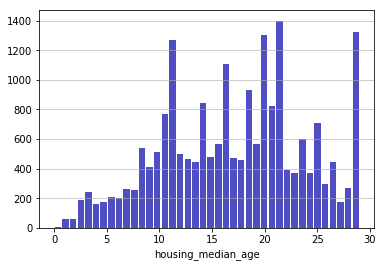

In [17]:
from scipy import stats

housing_median_age_bc, maxlog, interval = stats.boxcox(housing.housing_median_age, alpha=0.05)
print("lambda = {:g}".format(maxlog))
#print(xt)
#print("lambda = {:g}".format(maxlog))
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.housing_median_age, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('housing_median_age')
plt.grid(axis='y', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(x=housing_median_age_bc, bins='auto',color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('housing_median_age')
plt.grid(axis='y', alpha=0.75)
plt.show()

lambda = 0.220783


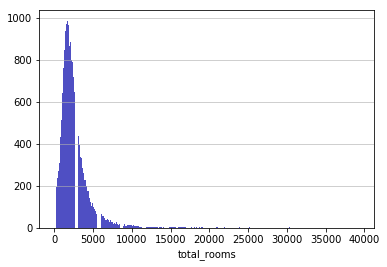

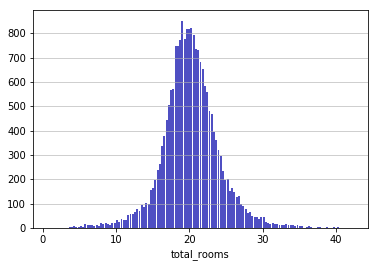

In [18]:
from scipy import stats

total_rooms_bc, maxlog, interval = stats.boxcox(housing.total_rooms, alpha=0.05)
print("lambda = {:g}".format(maxlog))
#print(xt)
#print("lambda = {:g}".format(maxlog))
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.total_rooms, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('total_rooms')
plt.grid(axis='y', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(x=total_rooms_bc, bins='auto',color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('total_rooms')
plt.grid(axis='y', alpha=0.75)
plt.show()

lambda = 0.224381


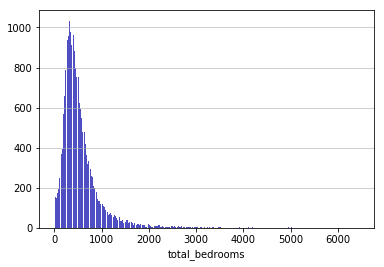

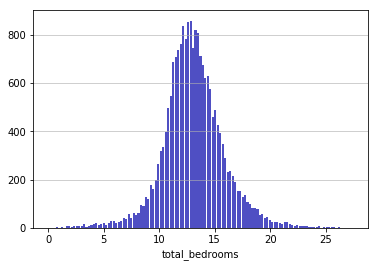

In [19]:
from scipy import stats

total_bedrooms_bc, maxlog, interval = stats.boxcox(housing.total_bedrooms, alpha=0.05)
print("lambda = {:g}".format(maxlog))
#print("lambda = {:g}".format(maxlog))
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.total_bedrooms, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('total_bedrooms')
plt.grid(axis='y', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(x=total_bedrooms_bc, bins='auto',color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('total_bedrooms')
plt.grid(axis='y', alpha=0.75)
plt.show()

lambda = 0.235768


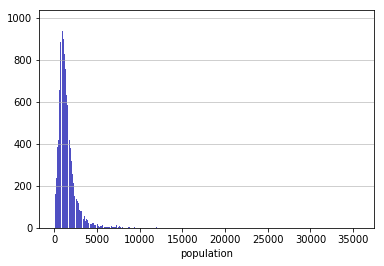

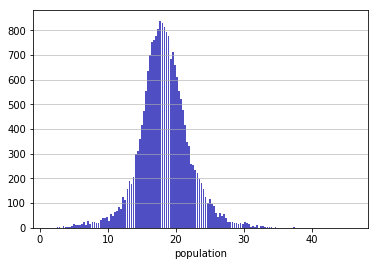

In [20]:
from scipy import stats

population_bc, maxlog, interval = stats.boxcox(housing.population, alpha=0.05)
print("lambda = {:g}".format(maxlog))
#print("lambda = {:g}".format(maxlog))
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.population, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('population')
plt.grid(axis='y', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(x=population_bc, bins='auto',color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('population')
plt.grid(axis='y', alpha=0.75)
plt.show()

lambda = 0.244929


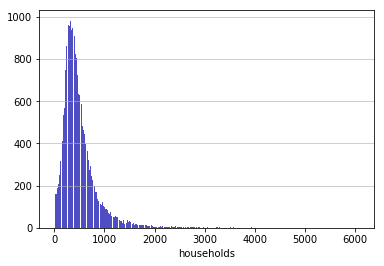

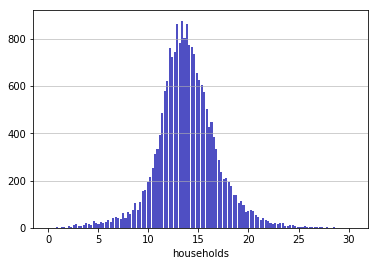

In [21]:
from scipy import stats

households_bc, maxlog, interval = stats.boxcox(housing.households, alpha=0.05)
print("lambda = {:g}".format(maxlog))
#print("lambda = {:g}".format(maxlog))
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.households, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('households')
plt.grid(axis='y', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(x=households_bc, bins='auto',color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('households')
plt.grid(axis='y', alpha=0.75)
plt.show()

lambda = 0.0908545


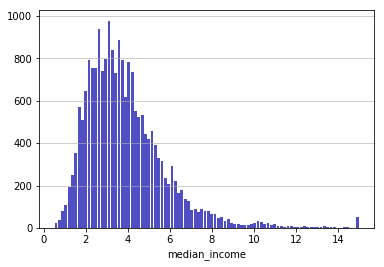

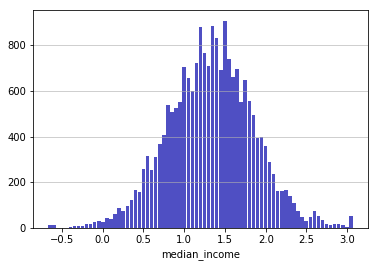

In [22]:
from scipy import stats

median_income_bc, maxlog, interval = stats.boxcox(housing.median_income, alpha=0.05)
print("lambda = {:g}".format(maxlog))
#print("lambda = {:g}".format(maxlog))
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=housing.median_income, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('median_income')
plt.grid(axis='y', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(x=median_income_bc, bins='auto',color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('median_income')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [23]:
housing_boxcox = housing.copy()

housing_boxcox.drop(columns=['housing_median_age'], inplace=True)
housing_boxcox.drop(columns=['total_rooms'], inplace=True)
housing_boxcox.drop(columns=['total_bedrooms'], inplace=True)
housing_boxcox.drop(columns=['population'], inplace=True)
housing_boxcox.drop(columns=['households'], inplace=True)
housing_boxcox.drop(columns=['median_income'], inplace=True)
housing_boxcox.drop(columns=['median_house_value'], inplace=True)

housing_boxcox['housing_median_age'] = housing_median_age_bc
housing_boxcox['total_rooms'] = total_rooms_bc
housing_boxcox['total_bedrooms'] = total_bedrooms_bc
housing_boxcox['population'] = population_bc
housing_boxcox['households'] = households_bc
housing_boxcox['median_income'] = median_income_bc
housing_boxcox['median_house_value'] = median_house_value_bc


print(housing_boxcox)

       longitude  latitude  1h_ocean  island  inland  near_ocean  near_bay  \
0        -122.23     37.88         0       0       0           0         1   
1        -122.22     37.86         0       0       0           0         1   
2        -122.24     37.85         0       0       0           0         1   
3        -122.25     37.85         0       0       0           0         1   
4        -122.25     37.85         0       0       0           0         1   
5        -122.25     37.85         0       0       0           0         1   
6        -122.25     37.84         0       0       0           0         1   
7        -122.25     37.84         0       0       0           0         1   
8        -122.26     37.84         0       0       0           0         1   
9        -122.25     37.84         0       0       0           0         1   
10       -122.26     37.85         0       0       0           0         1   
11       -122.26     37.85         0       0       0           0

In [24]:
# First, extract the data into arrays
y = housing_boxcox.median_house_value.values.reshape(-1,1)
X = housing_boxcox.drop(columns=['median_house_value'], inplace=False).values
print(X.shape)
print(y.shape)
# Pull out 1000 values into a holdout set
holdout = random.sample(range(0,10640),1000)
X_holdout = X[holdout]
y_holdout = y[holdout]
Xt = np.delete(X, holdout, 0)
yt = np.delete(y, holdout, 0)
print(Xt.shape)
print(yt.shape)
a=0.0
b=0.0
Model = lm.LinearRegression()
# Have to shuffle the data because it is grouped.
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(Xt):
    X_train, X_test = Xt[train_index], Xt[test_index]
    y_train, y_test = yt[train_index], yt[test_index]
    Model.fit(X_train, y_train)
    print('Training error: ' + str(Model.score(X_train, y_train)))
    print('Testing error: ' + str(Model.score(X_test, y_test)))
    a += Model.score(X_train, y_train)/5
    b += Model.score(X_test, y_test)/5
print('Average train error: ' + str(a))
print('Average test error: ' + str(b))  

(20640, 13)
(20640, 1)
(19640, 13)
(19640, 1)
Training error: 0.692559405354012
Testing error: 0.6947588912581459
Training error: 0.6946244671862902
Testing error: 0.6862742198507817
Training error: 0.6907831098121402
Testing error: 0.7019682977436779
Training error: 0.6935830767089134
Testing error: 0.690765795377587
Training error: 0.6942923053828444
Testing error: 0.6879093765368625
Average train error: 0.6931684728888401
Average test error: 0.6923353161534109


## the R2 score of different data transform:
|Data Transform       |R2     |
|---------------------|-------|
|Z-Score transform    |0.64579|
|Log transform        |0.63687|
|Log Normal Transform |0.65128|
|Box Cox Transform    |0.69372|


## After data transform, please use housing_boxcox as input